In [168]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib notebook
import random
import sys
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from IPython import display

In [197]:
sys.path.append("../src/")
from network import NormEmbeddingNet, NormClampEmbeddingNet, extract_embedding
from loss import OnlineTripletLoss, OnlineNonLinearTripletLoss
from metric import AverageNonZeroTripletsMetric
from trainer import fit
from sampler import BalancedBatchSampler, RandomNegativeTripletSelector, HardestNegativeTripletSelector, SemiHardNegativeTripletSelector, MarginallyHardNegativeTripletSelector
from display import plot_image, plot_2d_circle, plot_2d_embedding

In [198]:
plot_2d_embedding

<function display.plot_2d_embedding(embeddings, targets, ax, xlim=None, ylim=None, n_classes=2, kde=True, s=10)>

In [199]:
from importlib import reload
reload(display)

<module 'display' from '../src\\display.py'>

In [69]:
dict_args = dict()
dict_args["batch_size"] = 128
dict_args["no_cuda"] = False
dict_args["optimizer"] = "Adam"
dict_args["lr"] = 1e-2
dict_args["lambda_l2"] = 1e-5
dict_args["epochs"] = 50
dict_args["margin"] = 1.5
dict_args["log_interval"] = None
dict_args["seed"] = 1

use_cuda = not dict_args["no_cuda"] and torch.cuda.is_available()

torch.manual_seed(dict_args["seed"])

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 2,} if use_cuda else {}

print("use_cuda :", use_cuda)
print("device :", device)

use_cuda : True
device : cuda


In [4]:
def plot_data(X, label, auto=False, zoom=1):
    X = X.cpu()
    label = label.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=label, s=20, cmap=plt.cm.viridis)
    plt.axis('square')
    plt.axis(torch.Tensor((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: 
        plt.axis('equal')
    
    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)


def plot_model(X, label, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha=0.3)
    plot_data(X, label)


In [5]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
N = 500  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes
H = 100  # num_hidden_units

In [6]:
X = torch.zeros(N * C, D)
y = torch.zeros(N * C, dtype=torch.long)
for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    # When c = 0 and t = 0: start of linspace
    # When c = 0 and t = 1: end of linpace
    # This inner_var is for the formula inside sin() and cos() like sin(inner_var) and cos(inner_Var)
    inner_var = torch.linspace(
        # When t = 0
        (2 * math.pi / C) * (c),
        # When t = 1
        (2 * math.pi / C) * (2 + c),
        N
    ) + torch.randn(N) * 0.2
    
    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * torch.FloatTensor((
            math.sin(inner_var[index]), math.cos(inner_var[index])
        ))
        y[ix] = c
        index += 1

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes:
X: (1500, 2)
y: (1500,)


<IPython.core.display.Javascript object>


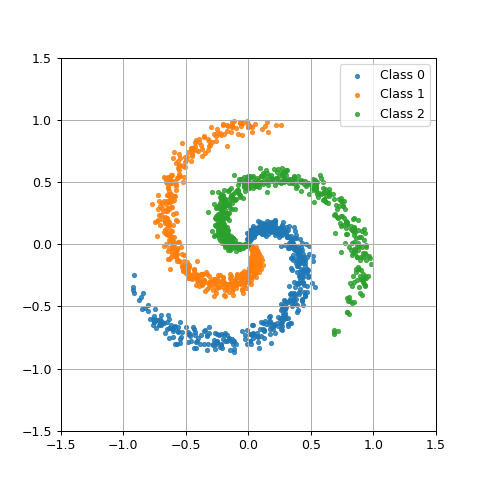

In [202]:
fig, ax = plt.subplots(figsize=(6,6))
# ax.scatter(X[:, 0], X[:, 1], c=y, label=[1])
# ax.grid()

plot_2d_embedding(X, 
                  y, 
                  ax=ax, xlim=[-1.5, 1.5], 
                  ylim=[-1.5, 1.5],
                  n_classes=C, kde=False)

In [13]:
inner_var

tensor([4.2066, 4.2509, 3.9746, 4.2020, 4.6229, 4.4869, 3.9969, 4.5041, 4.2877,
        4.4112, 4.1591, 4.7082, 4.4062, 4.7293, 4.5810, 4.1721, 4.2772, 4.3189,
        4.3667, 4.3472, 4.3938, 4.5108, 4.1764, 4.6285, 4.4970, 4.0826, 4.5068,
        4.4262, 4.3664, 4.5596, 4.4611, 4.7257, 4.3695, 4.6570, 4.6338, 4.6500,
        4.2194, 4.3940, 4.6843, 4.7517, 4.2672, 4.7333, 4.5429, 4.6983, 4.7872,
        4.4924, 4.7749, 4.7431, 4.6892, 4.7448, 4.6666, 4.4949, 4.5035, 4.6156,
        5.0183, 4.6175, 4.7280, 4.2281, 4.8279, 4.7334, 4.5748, 4.6200, 4.6425,
        4.8275, 4.9141, 5.0863, 4.9273, 5.1106, 4.4877, 4.8276, 4.7514, 4.8635,
        5.0407, 4.7417, 4.4152, 4.8623, 5.1456, 4.4428, 4.9184, 4.6787, 5.1001,
        4.8387, 4.4178, 4.6353, 5.0015, 4.6981, 4.7494, 5.1541, 4.9120, 4.9361,
        5.0131, 4.6721, 5.1861, 4.8857, 4.6137, 4.9988, 4.8726, 5.1163, 5.2344,
        5.3342, 5.2886, 5.1665, 4.9500, 4.8966, 5.1365, 4.9586, 4.7812, 4.9738,
        5.0906, 5.4161, 5.0730, 5.1702, 

In [14]:
# fig, ax = plt.subplots(figsize=(6,6))
# plt.plot([math.pow(v1,2)+math.pow(v2,2)+math.asin(v1)+math.asin(v1)+math.asin(v2)+math.asin(v2) for v1,v2 in zip(X[:,0], X[:,1])])

In [15]:
class SpiralDataset(Dataset):
    def __init__(self, X, y, n_neg=100):
        self.X = X
        self.labels = y

    def __getitem__(self, index):
        x = self.X[index, :]
        target = self.labels[index]
        return x, target

    def __len__(self):
        return len(self.labels)
    
ds = SpiralDataset(X.numpy(), y.numpy())

In [27]:
train_loader = DataLoader(ds, 
                         batch_size=dict_args["batch_size"], 
                         shuffle=False)

for batch_idx, (data, target) in enumerate(train_loader):
    print(data.shape, target.shape)
    break

train_batch_sampler = BalancedBatchSampler(ds, n_classes=C, n_samples=256)
online_train_loader = DataLoader(ds, batch_sampler=train_batch_sampler)

for batch_idx, (data, target) in enumerate(online_train_loader):
    print(data.shape, target.shape)
    break

torch.Size([128, 2]) torch.Size([128])
torch.Size([768, 2]) torch.Size([768])


In [208]:
# Select negative point when ap_distance + margin > an_distance 
loss_fn = OnlineNonLinearTripletLoss(MarginallyHardNegativeTripletSelector(dict_args["margin"]),
                                     max_dist=2,
                                     beta1=2,
                                     beta2=2.01,
                                     epsilon=1e-8)

# loss_fn = OnlineNonLinearTripletLoss(HardestNegativeTripletSelector(dict_args["margin"]),
#                                      max_dist=2,
#                                      beta1=2,
#                                      beta2=2.01,
#                                      epsilon=1e-8)

# loss_fn = OnlineNonLinearTripletLoss(RandomNegativeTripletSelector(dict_args["margin"]),
#                                      max_dist=2,
#                                      beta1=2,
#                                      beta2=2.01,
#                                      epsilon=1e-8)


In [43]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
from torch.nn.init import xavier_uniform_
import torch.nn.functional as F

def clamp_by_norm(t, p=2, dim=1, max_norm=1.0):
    t_norm = t.norm(p=p, dim=dim, keepdim=True)
    clip_coef = max_norm / t_norm
    t_max_norm = torch.Tensor([max_norm])
    if clip_coef.is_cuda:
        t_max_norm = t_max_norm.cuda()
    clip_coef = torch.min(clip_coef, t_max_norm)
    return t.mul(clip_coef.expand_as(t))

class RBF(nn.Module):
    """
    Transforms incoming data using a given radial basis function:
    u_{i} = rbf(||x - c_{i}|| / s_{i})
    Arguments:
        in_features: size of each input sample
        out_features: size of each output sample
    Shape:
        - Input: (N, in_features) where N is an arbitrary batch size
        - Output: (N, out_features) where N is an arbitrary batch size
    Attributes:
        centres: the learnable centres of shape (out_features, in_features).
            The values are initialised from a standard normal distribution.
            Normalising inputs to have mean 0 and standard deviation 1 is
            recommended.
        
        sigmas: the learnable scaling factors of shape (out_features).
            The values are initialised as ones.
        
        basis_func: the radial basis function used to transform the scaled
            distances.
    """

    def __init__(self, in_features, out_features, basis_func):
        super(RBF, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.centres = nn.Parameter(torch.Tensor(out_features, in_features))
        self.sigmas = nn.Parameter(torch.Tensor(out_features))
        self.basis_func = basis_func
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.centres, 0, 1)
        nn.init.constant_(self.sigmas, 1)

    def forward(self, input):
        size = (input.size(0), self.out_features, self.in_features)
#         print(size)
        x = input.unsqueeze(1).expand(size)
#         print(x.shape)
        c = self.centres.unsqueeze(0).expand(size)
        distances = (x - c).pow(2).sum(-1).pow(0.5) * self.sigmas.unsqueeze(0)
#         print("distances", distances.shape)
        return self.basis_func(distances)

# RBFs

def gaussian(alpha):
    phi = torch.exp(-1*alpha.pow(2))
    return phi

def linear(alpha):
    phi = alpha
    return phi

def quadratic(alpha):
    phi = alpha.pow(2)
    return phi

class NormClampEmbeddingNet(nn.Module):
    def __init__(self, 
                 p=2):
        super(NormClampEmbeddingNet, self).__init__()
                
        self.fc1 = nn.Sequential(
            nn.Linear(D, 20),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.Dropout(0.1),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            RBF(D, 20, gaussian),
            nn.Linear(20, 20),
            nn.Dropout(0.1),
            RBF(20, 20, gaussian)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(D, 20),
            nn.Dropout(0.1),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Dropout(0.1),
            nn.Tanh(),
        )
        self.fc4 = nn.Sequential(
            nn.Linear(60, 60),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(60, D),
            nn.Dropout(0.1),
        )
        
        self.p = p
#         self.init_weights()
    
#     def init_weights(self):
#         for linear in self.linears:
#             xavier_uniform_(linear.weight.data)
        
    def forward(self, x):
        out1 = self.fc1(x)
#         print(out1.shape)
        out2 = self.fc2(x)
        out3 = self.fc3(x)
#         print(out2.shape)
        out = torch.cat((out1,out2,out3), 1)
#         print(out.shape)
        out = self.fc4(out)
        # constrain embedding within unit norm
        out = clamp_by_norm(out, p=self.p, dim=1, max_norm=1.0)
        return out

    def get_embedding(self, x):
        return self.forward(x)
    
model = NormClampEmbeddingNet()

In [87]:
optimizer = getattr(torch.optim, dict_args["optimizer"])(model.parameters(), lr=1e-3, weight_decay=0)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

<IPython.core.display.Javascript object>


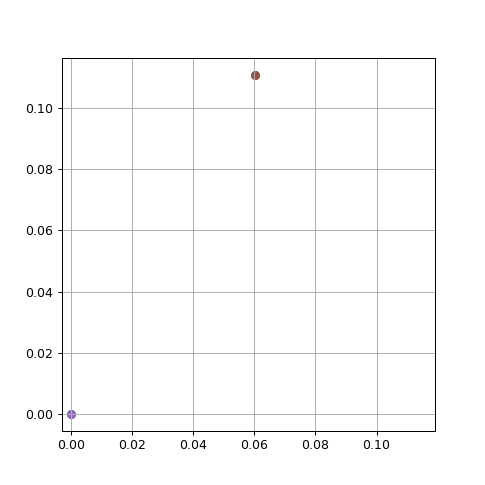

In [204]:
fig, ax = plt.subplots(figsize=(6,6))

with torch.no_grad():
    model.eval()
    indices = [0, 500, 1000]
    for i in indices:
        x = X[[i],:]
        plt.scatter(x[0, 0], x[0, 1])
        t = model(x[0:1,:].to(device)).cpu().numpy()
        plt.scatter(t[0,0], t[0,1])

plt.axis("square")
ax.grid()

In [148]:
X[[0, 500, 1000],:]

tensor([[-0., 0.],
        [0., -0.],
        [-0., -0.]])

<IPython.core.display.Javascript object>


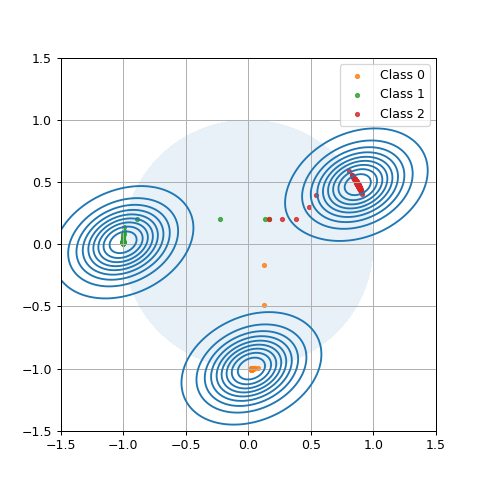

C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


In [210]:
model.to(device)
model.eval()
train_embeddings = model(X.to(device)).cpu().detach()
train_labels = y
fig, ax = plt.subplots(figsize=(6,6))
plot_2d_circle(ax)
plot_2d_embedding(train_embeddings, 
                  train_labels, 
                  ax=ax, xlim=[-1.5, 1.5], 
                  ylim=[-1.5, 1.5],
                  n_classes=C)


<IPython.core.display.Javascript object>


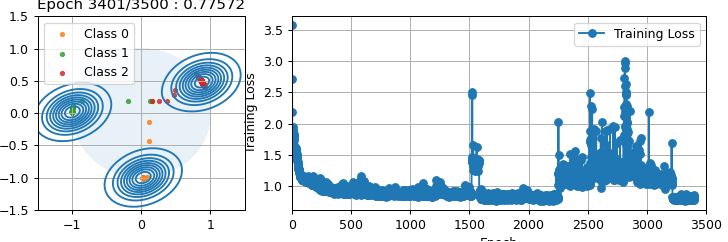

In [206]:
fig = plt.figure(figsize=(9, 3)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
fig.tight_layout()
fig.show()

In [52]:
dict_train_loss = {}
n_epochs = 1500
epoch = 0

In [90]:
n_epochs = 3500

In [ ]:
model = model.to(device)
while epoch < n_epochs:
    tmp_dict_train_loss, _ = fit(online_train_loader, 
                                         None, 
                                         model, 
                                         loss_fn, 
                                         optimizer, None, 
                                         epoch+1, 
                                         use_cuda, 
                                         dict_args["log_interval"], 
                                         metrics=[AverageNonZeroTripletsMetric()],
                                         start_epoch=epoch)
    dict_train_loss.update(tmp_dict_train_loss)
    
    train_embeddings, train_labels = extract_embedding(train_loader, model, use_cuda)
    
    ax = ax0
    ax.cla()
    plot_2d_circle(ax)
    plot_2d_embedding(train_embeddings, 
                  train_labels, 
                  ax=ax, xlim=[-1.5, 1.5], 
                  ylim=[-1.5, 1.5],
                     n_classes=C)
    
    ax.set_title("Epoch {}/{} : {:.5f}".format(epoch+1, n_epochs, tmp_dict_train_loss[epoch+1]))
    
    ax = ax1
    ax.cla()
    ax.plot(dict_train_loss.keys(), dict_train_loss.values(), marker="o", label="Training Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Training Loss")
    ax.set_xlim([0, n_epochs])
    ax.grid()
    ax.legend();
    
    fig.canvas.draw()
    epoch += 1

Epoch [3215/3215]: Avg. Train Loss: 0.82141 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3216/3216]: Avg. Train Loss: 0.79152 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3217/3217]: Avg. Train Loss: 0.79932 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3218/3218]: Avg. Train Loss: 0.81284 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3219/3219]: Avg. Train Loss: 0.78967 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3220/3220]: Avg. Train Loss: 0.81502 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3221/3221]: Avg. Train Loss: 0.79897 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3222/3222]: Avg. Train Loss: 0.81541 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3223/3223]: Avg. Train Loss: 0.79979 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3224/3224]: Avg. Train Loss: 0.81724 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3225/3225]: Avg. Train Loss: 0.80838 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3226/3226]: Avg. Train Loss: 0.81475 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3227/3227]: Avg. Train Loss: 0.81745 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3228/3228]: Avg. Train Loss: 0.77511 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3229/3229]: Avg. Train Loss: 0.81753 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3230/3230]: Avg. Train Loss: 0.79051 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3231/3231]: Avg. Train Loss: 0.82138 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3232/3232]: Avg. Train Loss: 0.80092 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3233/3233]: Avg. Train Loss: 0.82371 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3234/3234]: Avg. Train Loss: 0.82436 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3235/3235]: Avg. Train Loss: 0.80613 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3236/3236]: Avg. Train Loss: 0.80404 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3237/3237]: Avg. Train Loss: 0.83065 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3238/3238]: Avg. Train Loss: 0.82926 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3239/3239]: Avg. Train Loss: 0.80373 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3240/3240]: Avg. Train Loss: 0.80762 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3241/3241]: Avg. Train Loss: 0.79580 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3242/3242]: Avg. Train Loss: 0.83142 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3243/3243]: Avg. Train Loss: 0.78337 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3244/3244]: Avg. Train Loss: 0.82429 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3245/3245]: Avg. Train Loss: 0.80524 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3246/3246]: Avg. Train Loss: 0.79211 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3247/3247]: Avg. Train Loss: 0.81478 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3248/3248]: Avg. Train Loss: 0.78304 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3249/3249]: Avg. Train Loss: 0.79829 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3250/3250]: Avg. Train Loss: 0.80827 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3251/3251]: Avg. Train Loss: 0.78892 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3252/3252]: Avg. Train Loss: 0.78021 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3253/3253]: Avg. Train Loss: 0.80464 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3254/3254]: Avg. Train Loss: 0.77260 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3255/3255]: Avg. Train Loss: 0.79356 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3256/3256]: Avg. Train Loss: 0.78087 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3257/3257]: Avg. Train Loss: 0.79176 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3258/3258]: Avg. Train Loss: 0.80345 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3259/3259]: Avg. Train Loss: 0.79278 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3260/3260]: Avg. Train Loss: 0.81011 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3261/3261]: Avg. Train Loss: 0.81528 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3262/3262]: Avg. Train Loss: 0.81221 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3263/3263]: Avg. Train Loss: 0.82324 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3264/3264]: Avg. Train Loss: 0.82125 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3265/3265]: Avg. Train Loss: 0.79809 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3266/3266]: Avg. Train Loss: 0.82611 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3267/3267]: Avg. Train Loss: 0.81970 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3268/3268]: Avg. Train Loss: 0.80299 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3269/3269]: Avg. Train Loss: 0.81482 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3270/3270]: Avg. Train Loss: 0.78510 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3271/3271]: Avg. Train Loss: 0.83456 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3272/3272]: Avg. Train Loss: 0.80300 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3273/3273]: Avg. Train Loss: 0.80113 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3274/3274]: Avg. Train Loss: 0.81740 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3275/3275]: Avg. Train Loss: 0.81111 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3276/3276]: Avg. Train Loss: 0.80064 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3277/3277]: Avg. Train Loss: 0.84808 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3278/3278]: Avg. Train Loss: 0.80020 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3279/3279]: Avg. Train Loss: 0.80483 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3280/3280]: Avg. Train Loss: 0.82519 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3281/3281]: Avg. Train Loss: 0.81261 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3282/3282]: Avg. Train Loss: 0.82309 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3283/3283]: Avg. Train Loss: 0.80849 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3284/3284]: Avg. Train Loss: 0.77395 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3285/3285]: Avg. Train Loss: 0.86866 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3286/3286]: Avg. Train Loss: 0.82158 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3287/3287]: Avg. Train Loss: 0.82227 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3288/3288]: Avg. Train Loss: 0.81859 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3289/3289]: Avg. Train Loss: 0.81258 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3290/3290]: Avg. Train Loss: 0.78421 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3291/3291]: Avg. Train Loss: 0.81018 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3292/3292]: Avg. Train Loss: 0.83538 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3293/3293]: Avg. Train Loss: 0.80200 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3294/3294]: Avg. Train Loss: 0.81623 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3295/3295]: Avg. Train Loss: 0.80516 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3296/3296]: Avg. Train Loss: 0.82922 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3297/3297]: Avg. Train Loss: 0.78956 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3298/3298]: Avg. Train Loss: 0.79740 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3299/3299]: Avg. Train Loss: 0.80115 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3300/3300]: Avg. Train Loss: 0.82027 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3301/3301]: Avg. Train Loss: 0.82859 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3302/3302]: Avg. Train Loss: 0.81663 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3303/3303]: Avg. Train Loss: 0.81692 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3304/3304]: Avg. Train Loss: 0.79018 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3305/3305]: Avg. Train Loss: 0.80567 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3306/3306]: Avg. Train Loss: 0.81107 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3307/3307]: Avg. Train Loss: 0.80508 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3308/3308]: Avg. Train Loss: 0.79883 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3309/3309]: Avg. Train Loss: 0.80111 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3310/3310]: Avg. Train Loss: 0.81063 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3311/3311]: Avg. Train Loss: 0.80160 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3312/3312]: Avg. Train Loss: 0.81295 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3313/3313]: Avg. Train Loss: 0.80966 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3314/3314]: Avg. Train Loss: 0.79965 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3315/3315]: Avg. Train Loss: 0.82724 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3316/3316]: Avg. Train Loss: 0.78627 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3317/3317]: Avg. Train Loss: 0.81299 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3318/3318]: Avg. Train Loss: 0.81180 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3319/3319]: Avg. Train Loss: 0.76840 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3320/3320]: Avg. Train Loss: 0.80412 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3321/3321]: Avg. Train Loss: 0.82299 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3322/3322]: Avg. Train Loss: 0.80521 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3323/3323]: Avg. Train Loss: 0.81779 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3324/3324]: Avg. Train Loss: 0.81665 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3325/3325]: Avg. Train Loss: 0.79081 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3326/3326]: Avg. Train Loss: 0.79645 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3327/3327]: Avg. Train Loss: 0.78215 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3328/3328]: Avg. Train Loss: 0.82304 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3329/3329]: Avg. Train Loss: 0.80365 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3330/3330]: Avg. Train Loss: 0.81114 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3331/3331]: Avg. Train Loss: 0.81755 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3332/3332]: Avg. Train Loss: 0.81113 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3333/3333]: Avg. Train Loss: 0.87877 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3334/3334]: Avg. Train Loss: 0.82308 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3335/3335]: Avg. Train Loss: 0.81684 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3336/3336]: Avg. Train Loss: 0.80772 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3337/3337]: Avg. Train Loss: 0.82013 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3338/3338]: Avg. Train Loss: 0.79672 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3339/3339]: Avg. Train Loss: 0.79165 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3340/3340]: Avg. Train Loss: 0.79541 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3341/3341]: Avg. Train Loss: 0.82044 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3342/3342]: Avg. Train Loss: 0.80346 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3343/3343]: Avg. Train Loss: 0.81627 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3344/3344]: Avg. Train Loss: 0.81795 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3345/3345]: Avg. Train Loss: 0.83236 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3346/3346]: Avg. Train Loss: 0.80154 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3347/3347]: Avg. Train Loss: 0.81806 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3348/3348]: Avg. Train Loss: 0.81721 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3349/3349]: Avg. Train Loss: 0.77996 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3350/3350]: Avg. Train Loss: 0.81229 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3351/3351]: Avg. Train Loss: 0.78890 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3352/3352]: Avg. Train Loss: 0.78051 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3353/3353]: Avg. Train Loss: 0.81742 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3354/3354]: Avg. Train Loss: 0.78972 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3355/3355]: Avg. Train Loss: 0.82559 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3356/3356]: Avg. Train Loss: 0.81179 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3357/3357]: Avg. Train Loss: 0.78582 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3358/3358]: Avg. Train Loss: 0.83742 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3359/3359]: Avg. Train Loss: 0.79197 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3360/3360]: Avg. Train Loss: 0.81267 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3361/3361]: Avg. Train Loss: 0.81967 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3362/3362]: Avg. Train Loss: 0.81285 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3363/3363]: Avg. Train Loss: 0.82453 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3364/3364]: Avg. Train Loss: 0.80929 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3365/3365]: Avg. Train Loss: 0.80961 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3366/3366]: Avg. Train Loss: 0.77515 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3367/3367]: Avg. Train Loss: 0.84009 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3368/3368]: Avg. Train Loss: 0.78242 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3369/3369]: Avg. Train Loss: 0.78210 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3370/3370]: Avg. Train Loss: 0.82175 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3371/3371]: Avg. Train Loss: 0.80669 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3372/3372]: Avg. Train Loss: 0.81505 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3373/3373]: Avg. Train Loss: 0.79175 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3374/3374]: Avg. Train Loss: 0.82206 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3375/3375]: Avg. Train Loss: 0.82319 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3376/3376]: Avg. Train Loss: 0.77668 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3377/3377]: Avg. Train Loss: 0.80820 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3378/3378]: Avg. Train Loss: 0.78831 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3379/3379]: Avg. Train Loss: 0.82192 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3380/3380]: Avg. Train Loss: 0.77719 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3381/3381]: Avg. Train Loss: 0.79823 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3382/3382]: Avg. Train Loss: 0.82920 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3383/3383]: Avg. Train Loss: 0.79630 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3384/3384]: Avg. Train Loss: 0.82903 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3385/3385]: Avg. Train Loss: 0.80494 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3386/3386]: Avg. Train Loss: 0.80511 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3387/3387]: Avg. Train Loss: 0.82385 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3388/3388]: Avg. Train Loss: 0.80851 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3389/3389]: Avg. Train Loss: 0.78346 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3390/3390]: Avg. Train Loss: 0.79474 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3391/3391]: Avg. Train Loss: 0.82032 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3392/3392]: Avg. Train Loss: 0.79812 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3393/3393]: Avg. Train Loss: 0.79299 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3394/3394]: Avg. Train Loss: 0.82267 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3395/3395]: Avg. Train Loss: 0.78545 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3396/3396]: Avg. Train Loss: 0.82357 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3397/3397]: Avg. Train Loss: 0.82584 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3398/3398]: Avg. Train Loss: 0.85677 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3399/3399]: Avg. Train Loss: 0.80631 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3400/3400]: Avg. Train Loss: 0.83942 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Epoch [3401/3401]: Avg. Train Loss: 0.77572 | Avg. Non-Zero Triplets: 97920.00000


C:\Opt\Anaconda3\envs\pDL\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
